In [1]:
from brian2 import *
from matplotlib import pyplot as plt

%matplotlib inline
seed(12345)

In [2]:
start_scope()

################################################################################
# Model parameters
################################################################################
### General parameters
duration = 0.5*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step

N_sst = 100 # Number of SST neurons (inhibitory)
N_pv = 100  # Number of PV neurons (inhibitory)
N_cc = 100  # Number of CC neurons (excitatory)
N_cs = 100  # Number of CS neurons (excitatory)

### Neuron parameters
tau_S   = 16*ms  # 
tau_D   =  7*ms  #
tau_SST = 20*ms  #
tau_PV  = 10*ms  #
tau_E   =  5*ms  # Excitatory synaptic time constant
tau_I   = 10*ms  # Inhibitory synaptic time constant

C_S   = 370*pF
C_D   = 170*pF
C_SST = 100*pF
C_PV  = 100*pF

E_l  = -70*mV   # leak reversal potential
E_e  =   0*mV   # Excitatory synaptic reversal potential
E_i  = -80*mV   # Inhibitory synaptic reversal potential

V_t  = -50*mV   # spiking threashold
V_r  = E_l      # reset potential

c_d = 2600 * pA  # back-propagates somatic spikes to to the dendrites
g_s = 1300 * pA  # propagates dendritic regenerative activity to soma
g_d = 1200 * pA  # propagates dendritic regenerative activity to denderites



### Synapse parameters
w_e = 0.05*nS  # Excitatory synaptic conductance
w_i = 1.0*nS   # Inhibitory synaptic conductance


### External Input
g = 460*pA
M = 1.05 
I_ext_sst = [0*pA for i in range(N_sst)]
I_ext_pv = [0*pA for i in range(N_sst)]
I_ext_cs = [g for i in range(N_sst)]
I_ext_cc = [g for i in range(N_sst)]

################################################################################

In [3]:
### Sigmoid function params
E_d = -38*mV  # position control of threshold
D_d =   6*mV  # sharpness control of threshold 

# TODO see how to reference this from equation 
@check_units(x=volt, result=1)
def sigmoid(x):
    return 1/(1+np.exp(-(-x-E_d)/D_d))

In [4]:
eqs_sst_inh = '''
    dv/dt = ((E_l-v)/tau_SST + I/C_SST) : volt (unless refractory)

    dg_e/dt = -g_e/tau_E : siemens
    dg_i/dt = -g_i/tau_I : siemens

    I = I_external + I_syn : amp
    I_syn = g_e*(E_e - v) + g_i*(E_i - v) : amp
    I_external : amp
'''

eqs_pv_inh = '''
    dv/dt = ((E_l-v)/tau_PV + I/C_PV) : volt (unless refractory)

    dg_e/dt = -g_e/tau_E : siemens
    dg_i/dt = -g_i/tau_I : siemens

    I = I_external + I_syn : amp
    I_syn = g_e*(E_e - v) + g_i*(E_i - v) : amp
    I_external : amp
'''

eqs_exc = '''
    dv_s/dt = ((E_l-v_s)/tau_S + (g_s*(1/(1+exp(-(v_d-E_d)/D_d))) + I_s)/C_S) : volt (unless refractory)

    dg_es/dt = -g_es/tau_E : siemens
    dg_is/dt = -g_is/tau_I : siemens

    I_s = I_external + I_syn_s : amp
    I_syn_s = g_es*(E_e - v_s) + g_is*(E_i - v_s) : amp
    I_external : amp

    dv_d/dt = ((E_l-v_d)/tau_D + (g_d*(1/(1+exp(-(v_d-E_d)/D_d))) + c_d*K + I_d)/C_D) : volt

    dg_ed/dt = -g_ed/tau_E : siemens
    dg_id/dt = -g_id/tau_I : siemens

    I_d = I_syn_d : amp
    I_syn_d = g_ed*(E_e - v_d) + g_id*(E_i - v_d) : amp
    K : 1
'''

In [5]:
# SST Neurons
sst_neurons = NeuronGroup(N_sst, model=eqs_sst_inh, threshold='v > V_t',
                              reset='v = E_l', refractory=8.3 * ms, method='euler')
sst_neurons.set_states({'I_external': I_ext_sst})
sst_neurons.v = 'E_l + rand()*(V_t-E_l)'
sst_neurons.g_e = 'rand()*w_e'
sst_neurons.g_i = 'rand()*w_i'

# PV Neurons
pv_neurons = NeuronGroup(N_pv, model=eqs_pv_inh, threshold='v > V_t',
                             reset='v = E_l', refractory=8.3 * ms, method='euler')
pv_neurons.set_states({'I_external': I_ext_pv})
pv_neurons.v = 'E_l + rand()*(V_t-E_l)'
pv_neurons.g_e = 'rand()*w_e'
pv_neurons.g_i = 'rand()*w_i'

# CS Neurons
cs_neurons = NeuronGroup(N_cs, model=eqs_exc, threshold='v_s > V_t',
                             reset='v_s = E_l', refractory=8.3 * ms, method='euler')
cs_neurons.set_states({'I_external': I_ext_cs})
cs_neurons.v_s = 'E_l + rand()*(V_t-E_l)'
cs_neurons.v_d = -70 * mV
cs_neurons.g_es = cs_neurons.g_ed = 'rand()*w_e'
cs_neurons.g_is = cs_neurons.g_id = 'rand()*w_i'

# CC Neurons
cc_neurons = NeuronGroup(N_cc, model=eqs_exc, threshold='v_s > V_t',
                             reset='v_s = E_l', refractory=8.3 * ms, method='euler')
cc_neurons.set_states({'I_external': I_ext_cc})
cc_neurons.v_s = 'E_l + rand()*(V_t-E_l)'
cc_neurons.v_d = -70 * mV
cc_neurons.g_es = cc_neurons.g_ed = 'rand()*w_e'
cc_neurons.g_is = cc_neurons.g_id = 'rand()*w_i'

In [6]:
# CS_CS 0, CS_SST 1, CS_PV 2, SST_CS 3, PV_CS 4, CC_CC 5, CC_SST 6, CC_PV 7, SST_CC 8, PV_CC 9, CC_CS 10, SST_PV 11, SST_SST 12, PV_PV 13, PV_SST 14, 
conn_probs = [0.16, 0.23, 0.18, 0.52, 0.43, 0.06, 0.26, 0.22, 0.13, 0.38, 0.09, 0.29, 0.1, 0.5, 0.14]

# SST <=> PV
conn_SST_PV = Synapses(sst_neurons, pv_neurons, on_pre='g_i+=w_i', name='SST_PV') # inhibitory
conn_SST_PV.connect(p=conn_probs[11])
conn_PV_SST = Synapses(pv_neurons, sst_neurons, on_pre='g_i+=w_i', name='PV_SST') # inhibitory
conn_PV_SST.connect(p=conn_probs[14])

# PV <=> PYR soma
## target CS soma
conn_PV_CSsoma = Synapses(pv_neurons, cs_neurons, on_pre='g_is+=w_i', name='PV_CSsoma') # inhibitory
conn_PV_CSsoma.connect(p=conn_probs[4])
conn_CSsoma_PV = Synapses(cs_neurons, pv_neurons, on_pre='g_e+=w_e', name='CSsoma_PV') # excitatory
conn_CSsoma_PV.connect(p=conn_probs[2])

## target CC soma
conn_PV_CCsoma = Synapses(pv_neurons, cc_neurons, on_pre='g_is+=w_i', name='PV_CCsoma') # inhibitory 
conn_PV_CCsoma.connect(p=conn_probs[9])
conn_CCsoma_PV = Synapses(cc_neurons, pv_neurons, on_pre='g_e+=w_e', name='CCsoma_PV') # excitatory
conn_CCsoma_PV.connect(p=conn_probs[7])

# SST <=> PYR soma
## target CS soma
conn_SST_CSsoma = Synapses(sst_neurons, cs_neurons, on_pre='g_is+=w_i', name='SST_CSsoma') # inhibitory (optional connection)
conn_SST_CSsoma.connect(p=conn_probs[3])
conn_CSsoma_SST = Synapses(cs_neurons, sst_neurons, on_pre='g_e+=w_e', name='CSsoma_SST') # excitatory
conn_CSsoma_SST.connect(p=conn_probs[1])

## taget CC soma
conn_SST_CCsoma = Synapses(sst_neurons, cc_neurons, on_pre='g_is+=w_i', name='SST_CCsoma') # inhibitory (optional connection)
conn_SST_CCsoma.connect(p=conn_probs[8])
conn_CCsoma_SST = Synapses(cc_neurons, sst_neurons, on_pre='g_e+=w_e', name='CCsoma_SST') # excitatory
conn_CCsoma_SST.connect(p=conn_probs[6])

# CC => CS 
## target CS soma
conn_SST_CCdendrite = Synapses(cc_neurons, cs_neurons, on_pre='g_es+=w_e', name='CC_CSsoma') # excitatory
conn_SST_CCdendrite.connect(p=conn_probs[10])

# self connections
conn_CSsoma_CSsoma = Synapses(cs_neurons, cs_neurons, on_pre='g_es+=w_e', name='CSsoma_CSsoma')  # excitatory
conn_CSsoma_CSsoma.connect(p=conn_probs[0])
backprop_CS = Synapses(cs_neurons, cs_neurons, on_pre={'up': 'K += 1', 'down': 'K -=1'},
                           delay={'up': 0.5 * ms, 'down': 2 * ms}, name='backprop_CS')
backprop_CS.connect(condition='i==j')  # Connect all CS neurons to themselves

conn_CCsoma_CCsoma = Synapses(cc_neurons, cc_neurons, on_pre='g_es+=w_e', name='CCsoma_CCsoma')  # excitatory
conn_CCsoma_CCsoma.connect(p=conn_probs[5])
backprop_CC = Synapses(cc_neurons, cc_neurons, on_pre={'up': 'K += 1', 'down': 'K -=1'},
                           delay={'up': 0.5 * ms, 'down': 2 * ms}, name='backprop_CC')
backprop_CC.connect(condition='i==j')  # Connect all CC neurons to themselves

conn_SST_SST = Synapses(sst_neurons, sst_neurons, on_pre='g_i+=w_i', name='SST_SST')  # inhibitory
conn_SST_SST.connect(p=conn_probs[12])

conn_PV_PV = Synapses(pv_neurons, pv_neurons, on_pre='g_i+=w_i', name='PV_PV')  # inhibitory
conn_PV_PV.connect(p=conn_probs[13])


# SST => PYR dendrite
## target CS dendrite
conn_SST_CSdendrite = Synapses(sst_neurons, cs_neurons, on_pre='g_id+=w_i', name='SST_CSdendrite') # inhibitory
conn_SST_CSdendrite.connect(p=conn_probs[3]) # not sure about this here

## target CC dendrite
conn_SST_CCdendrite = Synapses(sst_neurons, cc_neurons, on_pre='g_id+=w_i', name='SST_CCdendrite') # inhibitory
conn_SST_CCdendrite.connect(p=conn_probs[8]) # not sure about this here



WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


In [7]:
# ##############################################################################
# # Monitors
# ##############################################################################

# Record spikes of different neuron groups
spike_mon_sst = SpikeMonitor(sst_neurons)
spike_mon_pv = SpikeMonitor(pv_neurons)
spike_mon_cs = SpikeMonitor(cs_neurons)
spike_mon_cc = SpikeMonitor(cc_neurons)

# Record conductances and membrane potential of neuron ni
state_mon_sst = StateMonitor(sst_neurons, ['v', 'g_e', 'g_i'], record=[0])
state_mon_pv = StateMonitor(pv_neurons, ['v', 'g_e', 'g_i'], record=[0])
state_mon_cs = StateMonitor(cs_neurons, ['v_s', 'v_d', 'g_es', 'g_is', 'g_ed', 'g_id'], record=[0])
state_mon_cc = StateMonitor(cc_neurons, ['v_s', 'v_d', 'g_es', 'g_is', 'g_ed', 'g_id'], record=[0])

In [8]:
# ##############################################################################
# # Simulation run
# ##############################################################################

defaultclock.dt = sim_dt

run(duration, report='text')

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s


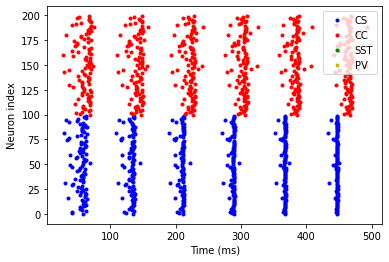

In [9]:
################################################################################
# Analysis and plotting
################################################################################

# Raster plot
plot(spike_mon_cs.t / ms, 0 + spike_mon_cs.i, '.b', label='CS')
plot(spike_mon_cc.t / ms, N_cs + spike_mon_cc.i, '.r', label='CC')
plot(spike_mon_sst.t / ms, (N_cs + N_cc) + spike_mon_sst.i, '.g', label='SST')
plot(spike_mon_pv.t / ms, (N_cs + N_cc + N_sst) + spike_mon_pv.i, '.y', label='PV')
xlabel('Time (ms)')
ylabel('Neuron index');
legend(loc='best')

Spike times CS: [ 30.1  31.6  32.2  34.   35.7  35.9  36.6  36.8  38.   39.   41.1  41.3
  41.8  42.   43.7  45.5  47.5  49.   49.1  49.6  49.6  49.9  50.2  51.
  51.9  52.3  53.2  53.4  53.5  53.9  54.   54.2  54.2  54.4  54.4  55.1
  55.2  55.4  55.6  55.8  55.9  56.1  56.2  56.3  56.4  56.6  56.8  56.9
  56.9  57.1  57.6  57.7  57.8  58.   58.   58.2  58.3  58.3  58.4  58.4
  58.6  58.8  58.9  59.1  59.2  59.2  59.3  59.5  59.7  59.7  60.   60.1
  60.5  60.7  60.8  60.9  61.1  61.4  61.5  61.7  61.7  61.9  62.1  62.2
  62.3  62.4  62.6  62.7  62.8  62.8  62.9  63.   63.3  63.4  63.6  63.8
  64.   64.1  64.5  69.2 109.5 111.4 113.1 116.3 116.5 117.6 118.4 118.6
 118.6 118.9 121.2 121.8 122.3 123.6 123.7 128.1 128.2 128.3 128.4 128.6
 129.2 129.2 129.2 129.4 129.4 129.5 130.  131.3 131.6 131.7 131.8 131.9
 132.2 132.7 132.8 132.8 133.1 133.1 133.1 133.4 133.4 133.6 133.7 133.7
 133.8 133.9 133.9 133.9 134.  134.  134.1 134.2 134.3 134.3 134.3 134.4
 134.5 134.6 134.7 134.7 134.7 134.8

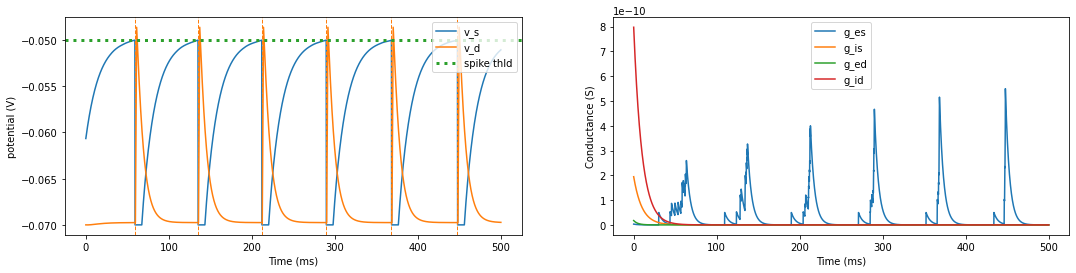

In [10]:
# CS Neurons plot

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_cs.t / ms, state_mon_cs.v_s[0], label='v_s')
plot(state_mon_cs.t / ms, state_mon_cs.v_d[0], label='v_d')
for (t, i) in zip(spike_mon_cs.t, spike_mon_cs.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3, label='spike thld')
xlabel('Time (ms)')
ylabel('potential (V)')
legend(loc='upper right')

subplot(1, 2, 2)
plot(state_mon_cs.t / ms, state_mon_cs.g_es[0], label='g_es')
plot(state_mon_cs.t / ms, state_mon_cs.g_is[0], label='g_is')
plot(state_mon_cs.t / ms, state_mon_cs.g_ed[0], label='g_ed')
plot(state_mon_cs.t / ms, state_mon_cs.g_id[0], label='g_id')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times CS: %s" % spike_mon_cs.t[:])

Spike times CC: [ 27.2  29.8  33.   36.8  37.3  41.8  42.1  43.   43.7  45.1  46.   46.3
  47.3  48.4  48.4  49.1  49.2  49.4  50.5  50.7  51.5  52.3  52.3  54.2
  54.9  54.9  55.8  56.5  56.5  56.7  56.8  57.4  57.5  57.6  58.5  58.6
  59.   59.1  59.3  59.5  59.5  60.   60.5  60.8  61.2  61.5  62.2  62.5
  63.3  63.6  65.   65.   65.5  65.5  65.6  65.7  65.7  65.8  66.1  66.4
  67.1  67.3  67.4  67.4  67.6  67.8  67.8  67.8  67.8  68.   68.1  68.2
  68.2  68.3  68.4  68.5  68.6  68.6  68.7  68.9  69.1  69.1  69.5  69.7
  69.8  69.8  69.9  69.9  70.   70.   70.1  70.2  70.5  70.6  70.7  71.1
  71.2  71.2  73.4  74.6 109.8 112.5 115.4 118.1 119.7 122.  123.6 126.
 126.3 127.  128.4 128.5 129.1 129.4 130.1 130.6 131.6 131.7 131.9 132.2
 132.5 133.3 134.5 135.8 136.5 136.7 137.5 137.8 138.2 138.2 138.3 138.4
 139.1 139.3 139.6 139.9 139.9 140.1 140.8 140.8 141.3 141.6 141.7 141.7
 141.8 141.8 142.5 142.5 142.9 143.9 144.  144.3 144.4 144.5 145.1 145.2
 145.2 145.5 145.5 145.6 145.8 146.1

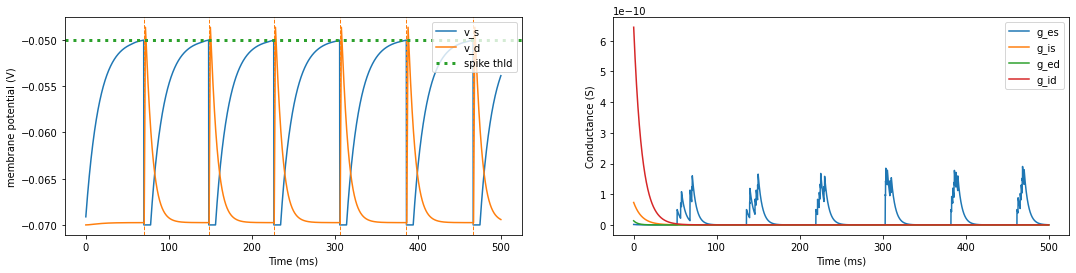

In [11]:
# CC Neurons

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_cc.t / ms, state_mon_cc.v_s[0], label='v_s')
plot(state_mon_cc.t / ms, state_mon_cc.v_d[0], label='v_d')
for (t, i) in zip(spike_mon_cc.t, spike_mon_cc.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3, label='spike thld')
xlabel('Time (ms)')
ylabel('membrane potential (V)')
legend(loc='upper right')

subplot(1, 2, 2)
plot(state_mon_cc.t / ms, state_mon_cc.g_es[0], label='g_es')
plot(state_mon_cc.t / ms, state_mon_cc.g_is[0], label='g_is')
plot(state_mon_cc.t / ms, state_mon_cc.g_ed[0], label='g_ed')
plot(state_mon_cc.t / ms, state_mon_cc.g_id[0], label='g_id')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times CC: %s" % spike_mon_cc.t[:])

Spike times SST: [] s


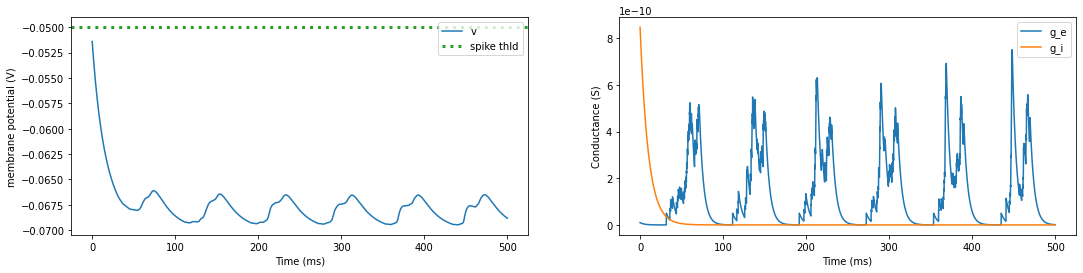

In [12]:
# SST Neurons plot

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_sst.t / ms, state_mon_sst.v[0], label='v')
for (t, i) in zip(spike_mon_sst.t, spike_mon_sst.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3, label='spike thld')
xlabel('Time (ms)')
ylabel('membrane potential (V)')
legend(loc='upper right')

subplot(1, 2, 2)
plot(state_mon_sst.t / ms, state_mon_sst.g_e[0], label='g_e')
plot(state_mon_sst.t / ms, state_mon_sst.g_i[0], label='g_i')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times SST: %s" % spike_mon_sst.t[:])

Spike times PV: [] s


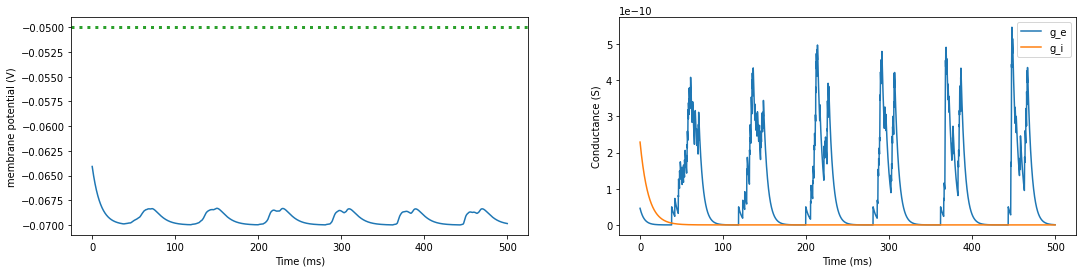

In [13]:
# PV Neurons plot

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_pv.t / ms, state_mon_pv.v[0], label='v')
for (t, i) in zip(spike_mon_pv.t, spike_mon_pv.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3)
xlabel('Time (ms)')
ylabel('membrane potential (V)')

subplot(1, 2, 2)
plot(state_mon_pv.t / ms, state_mon_pv.g_e[0], label='g_e')
plot(state_mon_pv.t / ms, state_mon_pv.g_i[0], label='g_i')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times PV: %s" % spike_mon_pv.t[:])